<p align="center">
    <img src="https://ars.els-cdn.com/content/image/3-s2.0-B9780081002858000055-f05-13-9780081002858.jpg" width="220" height="240" />

</p>

# Minimum Viable Product - Rod Pump Optimization

## Inventors Program Energy - NSC 325

#### Written by: Nicholas Khami, Nashra Ali, Vrishank Jannu

This notebook presents an implementation of a Random Forest Regression to predict the timing of a sucker rod pump failure. The data used for building the following model is provided by ConocoPhillips. The aim of this product is to assist production engineers in hypothesizing a better design for the downhole set-up in order to extend pump lifetimes. Thus, the company can cut yearly maintainence costs (i.e. part replacement) and consequently see an increase oil production per well. This benefits the company in guranteeing a higher return on their investments. 


### Imports

In [116]:
import glob
from datetime import datetime
import pandas as pd
import numpy as np
from scipy import stats
from scipy.integrate import quad
from scipy.optimize import curve_fit
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
from statsmodels.stats.outliers_influence import variance_inflation_factor 

### Exploring Data Analysis and Cleanup
To begin approaching the problem, it is important to get a feel for the data that we will be working with. The following code displays the head of the data and dataframe properties. The data documents mechanical and chemical parameters of various sucker rod pumps owned by ConocoPhillips.

In [117]:
rpdf = pd.read_csv("../UT_RodPump_Dataset/rodpump_failure.csv")
rpdf.head()

,roduid,UWI,NODEID,IDWELL,tbguid,lifetime_start,lifetime_end,IDRECJOBPULL,REPORTTO,FAILSTART,FAILURETYPE,H2S_CONCENTRATION,PrimarySetpoint,SecondarySetpoint,StrokeLength,GrossStrokeLength,Fillage,YesterdaysAverageSPM,bha_configuration,chemgroup1_any,chemgroup1_all,chemgroup2_any,chemgroup2_all,chemgroup3_any,chemgroup3_all,max_unguided_dls,dls_high_in_hole,gas_anchor_length,MAX_INCLINATION,wellbore_category,manual_scale,packer_vs_tac,AVG_PRESS_FLOWLINE,AVG_PRESSURE_TUBING,AVG_PRESSURE_CASING,AVG_DIFFERENTIAL_PRESSURE,AVG_OIL_VOLUME,AVG_WATER_VOLUME,AVG_LIQUID_VOLUME,AVG_WATERSG,rod_sinker_type,rod_has_guides,rod_make,rod_apigrade,ROUTE,overall_max_sideload,shallow_max_sideload,max_unguided_sideload,DESANDDEGAS_TYP,CHROME_LENGTH,ENDURALLOY_LENGTH,POLY_LENGTH,NIPPLE_SET_DEPTH,pump_bore,gasanchor_od
0,GB27GKBE51029074693667,175-58-0111,box-child-doctor,GPVO63973435661154,GB55QFGB46756147811400,2014-05-02 00:00:00.000,2019-01-04 10:00:00.000,FGNB86581338411987,Tubing,2018-12-11 00:00:00.000,Tubing,0,75,60,144,108,91,6,TAC_ABOVE_NIP,1,1,1,1,0,0,2,1,19,2,Vertical,N,OTHER_ANCHOR,60,74,53,-21,51,59,109,1,SINKER_BARS_W_GUIDED_SUBS,False,strategize next-generation users,D,900,NaN,NaN,NaN,UNKNOWN,0,0,0,10025,1.5,NaN
1,GB53OEVX46438297645035,333-68-3523,outside-worry,ZAYT33358197650329,GB29QCCC14341267287129,2018-01-28 14:00:00.000,2019-05-17 12:00:00.000,XRYU81281518151403,Tubing,2019-04-01 00:00:00.000,Tubing,0,80,62,168,173,2,0,TAC_BELOW_NIP,1,1,0,0,0,0,2,2,17,2,Vertical,N,OTHER_ANCHOR,54,77,88,12,91,17,109,NaN,SINKER_BARS_W_GUIDED_SUBS,False,mesh enterprise portals,SpecialService,882,179,179,179,Miller LLC,0,0,0,10236,1.5,3.5
2,GB95BPWW35640301552066,165-51-5897,near-learn-simply,FNVL11432909873086,GB02DJAW44801752494129,2011-09-14 00:00:00.000,2012-08-20 00:00:00.000,PLPR44121073149707,Sucker Rod Pump,2012-08-01 00:00:00.000,Sucker Rod Pump,0,75,60,144,NaN,NaN,NaN,PACKER_DONNAN,0,0,0,0,0,0,5,5,21,2,Vertical,N,arrowset,NaN,74,56,-18,46,10,57,NaN,SLICK_SINKER_BARS,False,mesh enterprise portals,D,880,106,106,106,Miller LLC,0,0,0,10402,1.5,NaN
3,GB79UEDN31454825972680,543-56-3494,sea-improve-place,JOKL33317998159514,GB84GHPH97287631470412,2016-01-12 09:00:00.000,2017-03-16 16:30:00.000,MYCF04792093856141,Sucker Rod Pump,2017-01-19 00:00:00.000,Sucker Rod Pump,0,75,60,144,NaN,86,6,TAC_ABOVE_NIP,1,0,1,0,0,0,2,0,17,1,Vertical,Y,OTHER_ANCHOR,NaN,72,102,30,85,28,113,1,SINKER_BARS_W_GUIDED_SUBS,False,strategize next-generation users,D,875,98,48,98,Miller LLC,0,0,0,9558,1.75,4.5
4,GB20XCTM13691331349509,391-37-2039,personal-candidate,XOSU92041716672870,GB08VYTX61977431827206,2018-06-14 13:00:00.000,2020-04-15 17:37:11.338,WJDB83445325478746,NaN,NaN,NaN,0,80,65,168,127,61,4,TAC_BELOW_NIP,1,0,0,0,0,0,2,4,17,4,LowTangent,N,OTHER_ANCHOR,61,76,123,34,77,16,93,1,SUCKER_RODS_W_GUIDES,True,mesh enterprise portals,SpecialService,875,267,267,171,Miller LLC,0,129,0,9682,1.75,NaN


We now want to look at the summary statistics for each numeric feature and unique counts for the categorical features to give us an idea of what features may be important to keep.

In [118]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)
pd.set_option('display.max_columns', 55)
rpdf_numeric_summary = rpdf.describe()
rpdf_numeric_summary

,H2S_CONCENTRATION,PrimarySetpoint,SecondarySetpoint,StrokeLength,GrossStrokeLength,Fillage,YesterdaysAverageSPM,chemgroup1_any,chemgroup1_all,chemgroup2_any,chemgroup2_all,chemgroup3_any,chemgroup3_all,max_unguided_dls,dls_high_in_hole,gas_anchor_length,MAX_INCLINATION,AVG_PRESS_FLOWLINE,AVG_PRESSURE_TUBING,AVG_PRESSURE_CASING,AVG_DIFFERENTIAL_PRESSURE,AVG_OIL_VOLUME,AVG_WATER_VOLUME,AVG_LIQUID_VOLUME,AVG_WATERSG,ROUTE,overall_max_sideload,shallow_max_sideload,max_unguided_sideload,CHROME_LENGTH,ENDURALLOY_LENGTH,POLY_LENGTH,NIPPLE_SET_DEPTH
count,2596,2596,2596,2596,1500,1984,1825,2596,2596,2596,2596,2596,2596,2547,2546,2592,2547,1661,2538,2544,2542,2578,2578,2578,1854,2596,1718,1717,1717,2596,2596,2596,2573
mean,10,75,57,148,131,82,5,0,0,0,0,0,0,3,2,17,5,58,86,116,30,82,42,124,1,883,195,183,166,7,48,24,9845
std,334,7,16,15,33,28,1,0,0,0,0,0,0,6,6,7,6,18,63,107,126,56,48,95,0,12,131,133,117,83,124,210,629
min,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-987,0,0,0,1,867,0,0,0,0,0,0,4066
25%,0,75,60,144,115,76,5,0,0,0,0,0,0,1,1,17,2,50,63,66,-2,43,15,64,1,873,104,86,93,0,0,0,9610
50%,0,75,60,144,129,87,6,0,0,0,0,0,0,2,2,19,2,60,78,93,15,72,31,107,1,882,173,159,143,0,0,0,9919
75%,0,75,65,146,146,95,6,1,0,0,0,0,0,3,3,21,6,67,100,139,50,109,52,159,1,886,255,247,207,0,0,0,10214
max,16500,91,100,336,655,655,8,1,1,1,1,1,1,92,92,45,53,248,1485,2322,4424,516,1067,1583,1,905,1351,1351,1351,1679,1559,3389,12070


In [119]:
rpdf_strobj_summary = rpdf.describe(include=['bool', 'object'])
rpdf_strobj_summary

,roduid,UWI,NODEID,IDWELL,tbguid,lifetime_start,lifetime_end,IDRECJOBPULL,REPORTTO,FAILSTART,FAILURETYPE,bha_configuration,wellbore_category,manual_scale,packer_vs_tac,rod_sinker_type,rod_has_guides,rod_make,rod_apigrade,DESANDDEGAS_TYP,pump_bore,gasanchor_od
count,2596,2596,2596,2596,2596,2596,2596,2596,1725,1725,1721,2550,2591,2596,2582,2596,2596,2596,2591,2596,2596,1488
unique,2596,633,632,633,1815,2408,1888,1693,4,1477,3,5,4,2,5,4,2,7,6,6,5,4
top,GB04MHKF87530184712041,540-51-3641,catch-gas-bill-cost,FOKS36813367797224,GB91LDLG69715047051923,2015-06-11 00:00:00.000,2020-04-15 17:37:11.338,WJDB83445325478746,Tubing,2013-03-01 00:00:00.000,Tubing,TAC_ABOVE_NIP,Vertical,N,OTHER_ANCHOR,SLICK_SINKER_BARS,False,mesh enterprise portals,SpecialService,Miller LLC,1.75,OtherOrUnknown
freq,1,15,15,15,6,4,591,871,899,6,899,914,1647,2250,1634,1737,1644,1433,1695,1394,1074,952


To begin visualizing the data, we will do a bivariate analysis with each pair of parameters to determine their relationship with each other so that we can drop some features in model training. The code below calculates and visualizes a correlation matrix of the numeric features. It appears that average oil volume, average liquid volume, and average water volume have high correlations to each other, so we can drop two of these variables when training our model. Overall max sideload and shallow max sideload also have a high correlation coefficient, so one of them may be dropped for training.

In [41]:
# corr = rpdf.select_dtypes(include=np.number).corr()# plot the heatmap
# fig, ax = plt.subplots(figsize=(20,20))
# sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

To begin cleaning, we convert unique well IDs to reformatted integer values and change lifetime_start, lifetime_end, and FAILSTART variables from date objects into integers. We create a new variable "lifetime" to represent the total time a particular pump operates (can be from the last failure time). This will serve as our response variable in the regression analysis. We will also at this stage drop rows with too many null values to be useful in training and testing.

In [120]:
rpdf = rpdf.dropna(subset=['FAILSTART'], axis=0)
rpdf['UWI'] = rpdf['UWI'].replace('-', '', regex=True).astype(int)

rpdf['lifetime_start'] = pd.to_datetime(rpdf['lifetime_start'], format="%Y-%m-%d %H:%M:%S.%f")
rpdf['lifetime_start'] = rpdf['lifetime_start'].astype(np.int64)

rpdf['lifetime_end'] = pd.to_datetime(rpdf['lifetime_end'], format="%Y-%m-%d %H:%M:%S.%f")
rpdf['lifetime_end'] = rpdf['lifetime_end'].astype(np.int64)

rpdf['FAILSTART'] = pd.to_datetime(rpdf['FAILSTART'], format="%Y-%m-%d %H:%M:%S.%f")
print(np.array(rpdf['FAILSTART'])[1])
print(np.array(rpdf['FAILSTART'])[1].astype(np.int64))
rpdf['FAILSTART'] = rpdf['FAILSTART'].astype(np.int64)

rpdf['pump_bore'].replace(to_replace="Other", value=0, inplace=True)
rpdf['pump_bore'] = rpdf['pump_bore'].astype(float)

rpdf['lifetime'] = rpdf['lifetime_end'] - rpdf['lifetime_start']
print(np.array(rpdf['lifetime_end'])[1])

2019-04-01T00:00:00.000000000
1554076800000000000
1558094400000000000


After the above, we found that there were several features such as StrokeLength and Fillage that we thought may be good predictors of failure, but they lacked differentiation throughout the dataframe. 

We think that the remaining features are promising because they have differentiation across their quartiles and strong representation throughout the dataframe. Additionally, we hypothesize that they will reflect overall stress on the Rod Pump. 

In [121]:
rpdf.drop(['GrossStrokeLength', 'YesterdaysAverageSPM', 'shallow_max_sideload', 'max_unguided_sideload', 'CHROME_LENGTH', 'ENDURALLOY_LENGTH', 'POLY_LENGTH', 'gasanchor_od', 'chemgroup3_all', 'REPORTTO','H2S_CONCENTRATION','AVG_OIL_VOLUME','dls_high_in_hole', 'roduid', 'UWI', 'NODEID', 'IDWELL', 'tbguid', 'IDRECJOBPULL', 'PrimarySetpoint', 'chemgroup3_any', 'AVG_WATERSG'], axis=1, inplace=True)
rpdf.drop(['AVG_PRESSURE_CASING','AVG_WATER_VOLUME','wellbore_category','manual_scale','rod_has_guides','rod_make','rod_apigrade','rod_sinker_type'], axis=1, inplace=True)
rpdf.drop(['MAX_INCLINATION'], axis=1, inplace=True)

Next, we assign an integer to each unique value for non-numeric columns of data (i.e. represented as integers or floats), known as label encoding. Any remaining null or incomprehensible (inf) values are replaced temporarily with null values.

In [122]:
labelencoder = LabelEncoder()
rpdf_cleaned = rpdf.copy()

rpdf_cleaned['FAILURETYPE'] = labelencoder.fit_transform(rpdf_cleaned['FAILURETYPE'])
rpdf_cleaned['bha_configuration'] = labelencoder.fit_transform(rpdf_cleaned['bha_configuration'])
#rpdf_cleaned['wellbore_category'] = labelencoder.fit_transform(rpdf_cleaned['wellbore_category'])
#rpdf_cleaned['manual_scale'] = labelencoder.fit_transform(rpdf_cleaned['manual_scale'])
rpdf_cleaned['packer_vs_tac'] = labelencoder.fit_transform(rpdf_cleaned['packer_vs_tac'])
#rpdf_cleaned['rod_has_guides'] = labelencoder.fit_transform(rpdf_cleaned['rod_has_guides'])
#rpdf_cleaned['rod_make'] = labelencoder.fit_transform(rpdf_cleaned['rod_make'])
#rpdf_cleaned['rod_apigrade'] = labelencoder.fit_transform(rpdf_cleaned['rod_apigrade'])
rpdf_cleaned['DESANDDEGAS_TYP'] = labelencoder.fit_transform(rpdf_cleaned['DESANDDEGAS_TYP'])
# rpdf_cleaned['rod_sinker_type'] = labelencoder.fit_transform(rpdf_cleaned['rod_sinker_type'])

rpdf_cleaned.fillna(np.nan, inplace=True)
rpdf_cleaned.replace([np.inf, -np.inf], np.nan, inplace=True)

<AxesSubplot:>

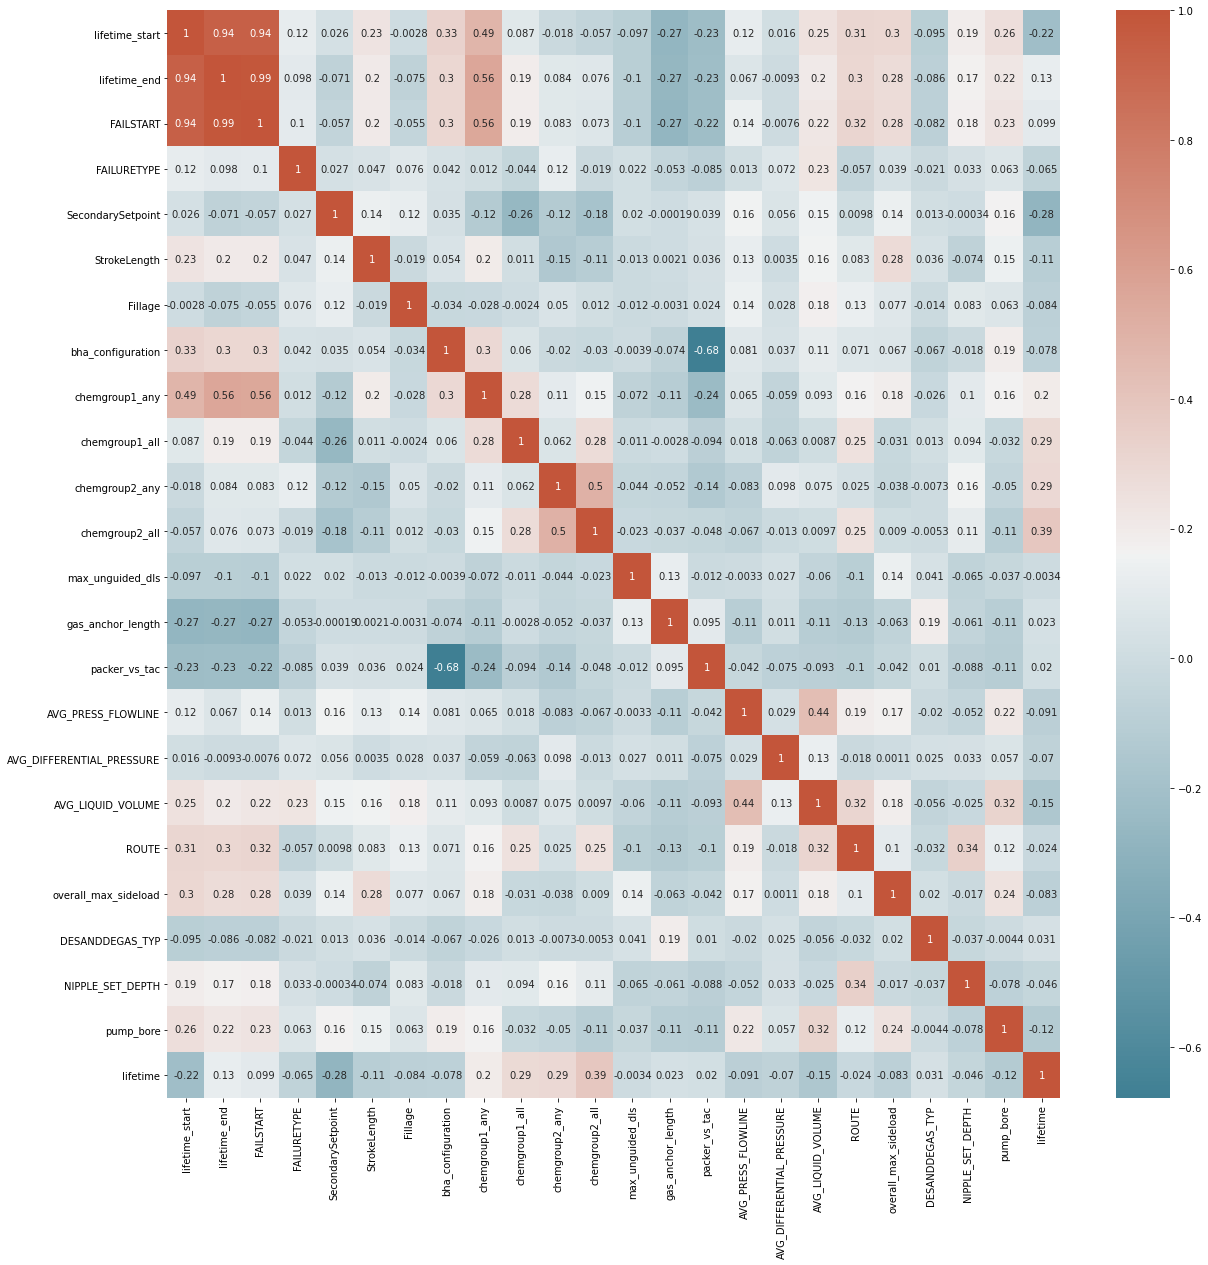

In [9]:
corr = rpdf_cleaned.corr()# plot the heatmap
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

To fill the remaining missing values, we perform a K-nearest-neighbor imputation

In [155]:
imputer = KNNImputer(n_neighbors=3, weights="uniform")
imputedR=pd.DataFrame(imputer.fit_transform(rpdf_cleaned))
imputedR.columns=rpdf_cleaned.columns
imputedR

,lifetime_start,lifetime_end,FAILSTART,FAILURETYPE,SecondarySetpoint,StrokeLength,Fillage,bha_configuration,chemgroup1_any,chemgroup1_all,chemgroup2_any,chemgroup2_all,max_unguided_dls,gas_anchor_length,packer_vs_tac,AVG_PRESS_FLOWLINE,AVG_PRESSURE_TUBING,AVG_DIFFERENTIAL_PRESSURE,AVG_LIQUID_VOLUME,ROUTE,overall_max_sideload,DESANDDEGAS_TYP,NIPPLE_SET_DEPTH,pump_bore,lifetime
0,1398988800000000000,1546596000000000000,1544486400000000000,2,60,144,91,3,1,1,1,1,2,19,0,60,74,-21,109,900,146,4,10025,2,147607200000000000
1,1517148000000000000,1558094400000000000,1554076800000000000,2,62,168,2,4,1,1,0,0,2,17,0,54,77,12,109,882,179,1,10236,2,40946400000000000
2,1315958400000000000,1345420800000000000,1343779200000000000,1,60,144,92,1,0,0,0,0,5,21,2,40,74,-18,57,880,106,1,10402,2,29462400000000000
3,1452589200000000000,1489681800000000000,1484784000000000000,1,60,144,86,3,1,0,1,0,2,17,0,54,72,30,113,875,98,1,9558,2,37092600000000000
4,1439942400000000000,1458691200000000000,1456444800000000000,2,60,168,78,3,0,0,1,0,2,17,0,41,97,34,161,883,85,4,10158,2,18748800000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1720,1423440000000000000,1453420800000000000,1450828800000000000,2,60,144,64,1,0,0,1,0,1,21,2,33,70,46,127,875,51,1,10153,2,29980800000000000
1721,1434326400000000000,1507714200000000000,1462665600000000000,0,65,144,77,3,1,0,1,0,1,17,0,58,56,75,35,885,54,1,9899,2,73387800000000000
1722,1542794400000000000,1546502400000000000,1543795200000000000,0,60,168,97,3,0,0,0,0,2,20,0,35,66,-5,43,900,165,5,9014,2,3708000000000000
1723,1368748800000000000,1371513600000000000,1370044800000000000,1,60,144,66,3,0,0,0,0,1,19,0,33,59,19,42,875,250,4,9532,2,2764800000000000


### Building the Model
We begin constructing our model by assigning a training and test set from the data. It is important that the training and test sets do not have any common data rows as this could affect the accuracy of our predictions. 70 percent of the cleaned data will be used for training while the remaining 30 percent will be used for testing.

In [124]:
X = imputedR.drop(['FAILSTART', 'lifetime_start', 'lifetime_end', 'lifetime'], axis=1)
y = rpdf_cleaned['lifetime']
print(np.array(y)[1])

#split the data again into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

40946400000000000


We now perform a grid search cross validation and randomized search cross validation to determine the best hyperparameters for the model. Based on score data, we will be using the hyperparameters determined by grid search CV for our random forest regression.

In [125]:
param_grid = {  'bootstrap': [True], 'max_depth': [5, 10, None], 'max_features': ['auto', 'log2'], 'n_estimators': [5, 6, 7, 8, 9, 10, 11, 12, 13, 15]}
rfr = RandomForestRegressor(random_state = 35)
g_search = GridSearchCV(estimator = rfr, param_grid = param_grid, cv = 3, n_jobs = 1, verbose = 0, return_train_score=True)
g_search.fit(X_train, y_train)
print(g_search.best_params_)

{'bootstrap': True, 'max_depth': None, 'max_features': 'log2', 'n_estimators': 15}


In [126]:
g_search.best_score_

0.5308072506684852

### Linear Regression

Text(0.5, 1.0, 'Residuals Plot of Lifetime in Months')

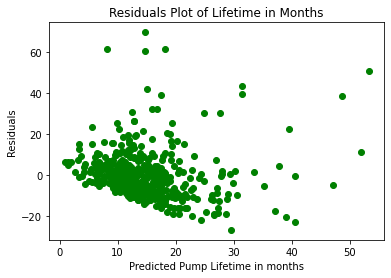

In [162]:
lr=LinearRegression()
y_train_months=y_train.copy()
y_train_months/=2.63002e+15
lr.fit(X_train,y_train_months)
prediction=lr.predict(X_test)
y_test_months=y_test.copy()
y_test_months/=2.63002e+15 #30.44 days per month
plt.scatter(prediction, y_test_months-prediction, color='green')
plt.xlabel('Predicted Pump Lifetime in months')
plt.ylabel('Residuals')
plt.title('Residuals Plot of Lifetime in Months')

In [56]:
rfr_random_reg = RandomForestRegressor(random_state = 35)
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)] # number of trees in the random forest
max_features = ['auto', 'sqrt', 'log2'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points
r_grid = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}
print(r_grid)

{'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120], 'min_samples_split': [2, 6, 10], 'min_samples_leaf': [1, 3, 4], 'bootstrap': [True, False]}


In [57]:
rfr_random = RandomizedSearchCV(estimator=rfr_random_reg, param_distributions=r_grid, n_iter = 20, scoring='neg_mean_absolute_error', cv = 3, verbose=2, random_state=42, n_jobs=-1, return_train_score=True)
rfr_random.fit(X_train, y_train)
print(rfr_random.best_score_)
print(rfr_random.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
-1.7223865228292792e+16
{'n_estimators': 17, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 100, 'bootstrap': False}


In [58]:
print(rfr_random.score(X_test , y_test))

-1.5892720592239122e+16


We now create a random forest regressor object and pass our training set to it. The following code displays the weights of each predictor variable in relation to their correlation with sucker rod pump lifespan.

<class 'numpy.ndarray'>
0 Feature: FAILURETYPE, Score: 0.01070
1 Feature: SecondarySetpoint, Score: 0.01282
2 Feature: StrokeLength, Score: 0.01481
3 Feature: Fillage, Score: 0.01698
4 Feature: bha_configuration, Score: 0.02092
5 Feature: chemgroup1_any, Score: 0.02307
6 Feature: chemgroup1_all, Score: 0.02626
7 Feature: chemgroup2_any, Score: 0.03799
8 Feature: chemgroup2_all, Score: 0.04936
9 Feature: max_unguided_dls, Score: 0.04960
10 Feature: gas_anchor_length, Score: 0.05201
11 Feature: packer_vs_tac, Score: 0.05319
12 Feature: AVG_PRESS_FLOWLINE, Score: 0.05336
13 Feature: AVG_PRESSURE_TUBING, Score: 0.05628
14 Feature: AVG_DIFFERENTIAL_PRESSURE, Score: 0.06542
15 Feature: AVG_LIQUID_VOLUME, Score: 0.06607
16 Feature: ROUTE, Score: 0.06681
17 Feature: overall_max_sideload, Score: 0.07463
18 Feature: DESANDDEGAS_TYP, Score: 0.07506
19 Feature: NIPPLE_SET_DEPTH, Score: 0.07593
20 Feature: pump_bore, Score: 0.09874


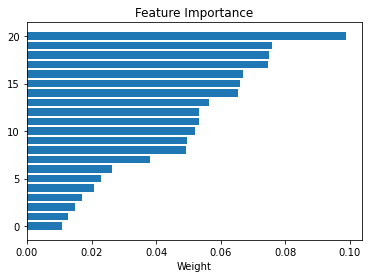

In [59]:
reg = RandomForestRegressor(bootstrap = True, max_depth = None, max_features = 'log2', n_estimators = 13)
reg.fit(X_train, y_train)
feature_names = list(X_train.columns)

importance = reg.feature_importances_
importance.sort()
print(type(importance))
# summarize feature importance
for i,v in enumerate(importance):
    if v < 1.0:
        print('%i Feature: %s, Score: %.5f' % (i,feature_names[i],v))
        
# plot feature importance
fig, ax = plt.subplots()

weightPlot = ax.barh(y=[x for x in range(len(importance))], width=importance)
#ax.set_yticklabels(imputedR.columns)
ax.set_xlabel('Weight')
ax.set_title('Feature Importance')

plt.show()

The R^2 value gives us an idea of how accurate our model is in prediciting sucker rod pump lifetimes.

In [60]:
#score it up
reg.score(X_test, y_test)
predictions = reg.predict(X_test)
type(y_test)

pandas.core.series.Series

In [61]:
max_error = 0
min_error = np.maximum
total_error = 0
for i in range(0, len(y_test)):
   date_error = np.abs(np.array(y_test)[i] - predictions[i])
   max_error = date_error if date_error > max_error else max_error
   min_error = date_error if date_error < max_error else min_error
   total_error += date_error

[max_error, min_error, total_error/len(X_test)]
print(np.array(y_test)[1])
datetime.fromtimestamp(1554076800000000000).strftime("%Y-%m-%d %H:%M:%S.%f")
   

76032000000000000


OSError: [Errno 22] Invalid argument

We can finally visualize the results of our model through the following graphic.

In [ ]:
# #and export so we can visualize what is going on
for k in range(12):
   dot_data = tree.export_graphviz(reg.estimators_[k+1], out_file='reggraph_' + str((k+1)), feature_names=X.columns, filled=True)